# Import Packages

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import confusion_matrix
try:
    from sklearn.preprocessing import OrdinalEncoder
    from sklearn.preprocessing import OneHotEncoder
except ImportError:
    from future_encoders import OneHotEncoder
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns

import nltk
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.model_selection import train_test_split
from matplotlib import cm
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.naive_bayes import MultinomialNB
import string, re

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/benspilsbury/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/benspilsbury/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/benspilsbury/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Stop Word Removal Function

In [35]:
sw_list = stopwords.words('english')
sw_list += list(string.punctuation)
sw_list += ["''", '""', '...', '``', '’', '“', '’', '”', '‘', '‘', '©',
            'said', 'one', 'com', 'satirewire', '-', '–', '—', 'satirewire.com']
sw_set = set(sw_list)

def process_article(article):
    tokens = nltk.word_tokenize(article)
    stopwords_removed = [token.lower() for token in tokens if token.lower() not in sw_set]
    return stopwords_removed 

# Read CSV and Split into Apple and Google

In [2]:
stop_words=set(stopwords.words("english"))

In [3]:
tweets=pd.read_csv('judge-1377884607_tweet_product_company.csv', encoding = 'unicode_escape')
tweets.tweet_text=tweets.tweet_text.map(lambda x: str(x))
tweets = tweets[tweets.is_there_an_emotion_directed_at_a_brand_or_product != "I can't tell"]
tweets=tweets.replace('Negative emotion', 0)
tweets=tweets.replace('Positive emotion', 1)
tweets=tweets.replace('No emotion toward brand or product', 2)
tweets.is_there_an_emotion_directed_at_a_brand_or_product=pd.to_numeric(tweets.is_there_an_emotion_directed_at_a_brand_or_product)

In [4]:
apple=tweets[(tweets.emotion_in_tweet_is_directed_at=='iPad') | 
      (tweets.emotion_in_tweet_is_directed_at=='Apple') |
      (tweets.emotion_in_tweet_is_directed_at=='iPad or iPhone App') | 
      (tweets.emotion_in_tweet_is_directed_at=='iPhone') |
      (tweets.emotion_in_tweet_is_directed_at=='Other Apple product or service')]
google=tweets[(tweets.emotion_in_tweet_is_directed_at=='Google') | 
      (tweets.emotion_in_tweet_is_directed_at=='Other Google product or service') |
      (tweets.emotion_in_tweet_is_directed_at=='Android App') | 
      (tweets.emotion_in_tweet_is_directed_at=='Android')]

# Lematize

In [5]:
from nltk.stem import WordNetLemmatizer 
  
lemmatizer = WordNetLemmatizer()

In [6]:
apple.tweet_text=apple['tweet_text'].map(lambda x: lemmatizer.lemmatize(x))
google.tweet_text=google['tweet_text'].map(lambda x: lemmatizer.lemmatize(x))

# Vectorize

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer
token = RegexpTokenizer(r'[a-zA-Z0-9]+')
cv_apple = CountVectorizer(lowercase=True,stop_words='english',ngram_range = (1,1), tokenizer = token.tokenize)
cv_google = CountVectorizer(lowercase=True,stop_words='english',ngram_range = (1,1), tokenizer = token.tokenize)
apple_text_counts= cv_apple.fit_transform(apple['tweet_text'])
google_text_counts= cv_google.fit_transform(google['tweet_text'])

# Build Dataframes

In [70]:
apple_df = pd.DataFrame(apple_text_counts.todense(), columns = cv_apple.get_feature_names())
google_df = pd.DataFrame(google_text_counts.todense(),columns = cv_google.get_feature_names())

# Test to Remove SXSW and Mention Stuff

In [71]:
apple_df=apple_df.drop(['sxsw', 'mention'], axis=1)
google_df=google_df.drop(['sxsw', 'mention'], axis=1)

# Google Train Test

In [65]:
# Establish features and target in data

gX=google_df
gy=google['is_there_an_emotion_directed_at_a_brand_or_product']

# Split features and target into training and testing partitions

gX_train, gX_test, gy_train, gy_test = train_test_split(gX, gy, random_state=1)

# Scale feature set according to standard distribution to make results more interpretable
scaler = StandardScaler()
scaler.fit(gX_train)
gX_train = scaler.transform(gX_train)  
gX_test = scaler.transform(gX_test)

# Google Decision Tree

In [66]:
# Establish decision tree model

gdtc = DecisionTreeClassifier(criterion= 'gini', class_weight='balanced', random_state=1)

# Fit decision tree model to training data

gdtc.fit(gX_train, gy_train)

# Make predictions on test set with model

gdtc_preds  = gdtc.predict(gX_test)

print(accuracy_score(gy_test, gdtc_preds))
print(f1_score(gy_test, gdtc_preds, pos_label='positive', average='weighted'))

0.7045454545454546
0.7350707634573063


# Apple Train Test

In [67]:
# Establish features and target in data

aX=apple_df
ay=apple['is_there_an_emotion_directed_at_a_brand_or_product']

# Split features and target into training and testing partitions

aX_train, aX_test, ay_train, ay_test = train_test_split(aX, ay, random_state=1)

# Scale feature set according to standard distribution to make results more interpretable
ascaler = StandardScaler()
ascaler.fit(aX_train)
aX_train = ascaler.transform(aX_train)  
aX_test = ascaler.transform(aX_test)

# Apple Decision Tree

In [68]:
# Establish decision tree model

adtc = DecisionTreeClassifier(criterion= 'gini', class_weight='balanced', random_state=1)

# Fit decision tree model to training data

adtc.fit(aX_train, ay_train)

# Make predictions on test set with model

adtc_preds  = adtc.predict(aX_test)

print(accuracy_score(ay_test, adtc_preds))
print(f1_score(ay_test, adtc_preds, pos_label='positive', average='weighted'))

0.7304492512479202
0.744511417932411


# Apple Frequencies

In [41]:
afreqpos=apple[apple['is_there_an_emotion_directed_at_a_brand_or_product']==1]
afreqneg=apple[apple['is_there_an_emotion_directed_at_a_brand_or_product']==0]
afreqneut=apple[apple['is_there_an_emotion_directed_at_a_brand_or_product']==2]

adatapos=afreqpos.tweet_text
adataneg=afreqneg.tweet_text
adataneut=afreqneut.tweet_text

apos = list(map(process_article, adatapos))
aneg = list(map(process_article, adataneg))
aneut = list(map(process_article, adataneut))

atotal_vocab_pos = set()
for comment in apos:
    atotal_vocab_pos.update(comment)

atotal_vocab_neg = set()
for comment in aneg:
    atotal_vocab_neg.update(comment)

atotal_vocab_neut = set()
for comment in aneut:
    atotal_vocab_neut.update(comment)
    
flat_apos = [item for sublist in apos for item in sublist]
flat_aneg = [item for sublist in aneg for item in sublist]
flat_aneut = [item for sublist in aneut for item in sublist]

apos_freq = FreqDist(flat_apos)
aneg_freq = FreqDist(flat_aneg)
aneut_freq = FreqDist(flat_aneut)

In [49]:
apos_freq.most_common(20)

apos_total_word_count = sum(apos_freq.values())
apos_top_25 = apos_freq.most_common(25)
print("Word \t\t Normalized Frequency")
print()
for word in apos_top_25:
    normalized_frequency = word[1]/apos_total_word_count
    print("{} \t\t {:.4}".format(word[0], normalized_frequency))

Word 		 Normalized Frequency

sxsw 		 0.08416
mention 		 0.0586
ipad 		 0.03733
apple 		 0.0346
link 		 0.03415
rt 		 0.02453
store 		 0.02013
iphone 		 0.0185
2 		 0.01752
's 		 0.01365
app 		 0.01198
quot 		 0.01019
austin 		 0.009699
new 		 0.008028
ipad2 		 0.00758
pop-up 		 0.005705
amp 		 0.005013
n't 		 0.004768
line 		 0.004646
get 		 0.004524
cool 		 0.00379
'm 		 0.003709
via 		 0.003383
opening 		 0.003383
temporary 		 0.003383


In [50]:
aneg_freq.most_common(20)

aneg_total_word_count = sum(aneg_freq.values())
aneg_top_25 = aneg_freq.most_common(25)
print("Word \t\t Normalized Frequency")
print()
for word in aneg_top_25:
    normalized_frequency = word[1]/aneg_total_word_count
    print("{} \t\t {:.4}".format(word[0], normalized_frequency))

Word 		 Normalized Frequency

sxsw 		 0.08209
mention 		 0.03951
ipad 		 0.03603
iphone 		 0.03009
quot 		 0.02354
apple 		 0.02313
rt 		 0.01617
n't 		 0.0131
's 		 0.01228
link 		 0.01187
2 		 0.01167
app 		 0.009621
store 		 0.008598
like 		 0.006346
design 		 0.004913
apps 		 0.004913
people 		 0.004913
austin 		 0.004708
new 		 0.004504
amp 		 0.004094
would 		 0.003889
get 		 0.00348
need 		 0.003275
news 		 0.003275
battery 		 0.003071


In [52]:
aneut_freq.most_common(20)

aneut_total_word_count = sum(aneut_freq.values())
aneut_top_25 = aneut_freq.most_common(25)
print("Word \t\t Normalized Frequency")
print()
for word in aneut_top_25:
    normalized_frequency = word[1]/aneut_total_word_count
    print("{} \t\t {:.4}".format(word[0], normalized_frequency))

Word 		 Normalized Frequency

sxsw 		 0.08649
mention 		 0.04621
ipad 		 0.03555
apple 		 0.03436
link 		 0.02725
store 		 0.02133
iphone 		 0.02014
rt 		 0.01896
quot 		 0.0154
n't 		 0.01185
's 		 0.01066
pop-up 		 0.009479
austin 		 0.009479
2 		 0.009479
app 		 0.008294
new 		 0.008294
'm 		 0.007109
call 		 0.005924
line 		 0.005924
still 		 0.004739
ipad2 		 0.004739
design 		 0.004739
get 		 0.004739
're 		 0.003555
front 		 0.003555


# Google Frequencies

In [45]:
gfreqpos=google[google['is_there_an_emotion_directed_at_a_brand_or_product']==1]
gfreqneg=google[google['is_there_an_emotion_directed_at_a_brand_or_product']==0]
gfreqneut=google[google['is_there_an_emotion_directed_at_a_brand_or_product']==2]

gdatapos=gfreqpos.tweet_text
gdataneg=gfreqneg.tweet_text
gdataneut=gfreqneut.tweet_text

gpos = list(map(process_article, gdatapos))
gneg = list(map(process_article, gdataneg))
gneut = list(map(process_article, gdataneut))

gtotal_vocab_pos = set()
for comment in gpos:
    gtotal_vocab_pos.update(comment)

gtotal_vocab_neg = set()
for comment in gneg:
    gtotal_vocab_neg.update(comment)

gtotal_vocab_neut = set()
for comment in gneut:
    gtotal_vocab_neut.update(comment)
    
flat_gpos = [item for sublist in gpos for item in sublist]
flat_gneg = [item for sublist in gneg for item in sublist]
flat_gneut = [item for sublist in gneut for item in sublist]

gpos_freq = FreqDist(flat_gpos)
gneg_freq = FreqDist(flat_gneg)
gneut_freq = FreqDist(flat_gneut)

In [53]:
gpos_freq.most_common(20)

gpos_total_word_count = sum(gpos_freq.values())
gpos_top_25 = gpos_freq.most_common(25)
print("Word \t\t Normalized Frequency")
print()
for word in gpos_top_25:
    normalized_frequency = word[1]/gpos_total_word_count
    print("{} \t\t {:.4}".format(word[0], normalized_frequency))

Word 		 Normalized Frequency

sxsw 		 0.07547
google 		 0.06409
mention 		 0.05251
link 		 0.02599
rt 		 0.02401
quot 		 0.01691
android 		 0.01503
new 		 0.01263
's 		 0.01117
circles 		 0.009812
maps 		 0.009603
party 		 0.009395
social 		 0.008873
network 		 0.007411
launch 		 0.007098
app 		 0.006785
mobile 		 0.006785
amp 		 0.006367
mayer 		 0.005846
great 		 0.005428
marissa 		 0.005324
today 		 0.005324
called 		 0.005219
major 		 0.004802
time 		 0.004697


In [54]:
gneg_freq.most_common(20)

gneg_total_word_count = sum(gneg_freq.values())
gneg_top_25 = gneg_freq.most_common(25)
print("Word \t\t Normalized Frequency")
print()
for word in gneg_top_25:
    normalized_frequency = word[1]/gneg_total_word_count
    print("{} \t\t {:.4}".format(word[0], normalized_frequency))

Word 		 Normalized Frequency

sxsw 		 0.07603
google 		 0.07197
mention 		 0.05281
rt 		 0.0267
quot 		 0.02554
link 		 0.01683
circles 		 0.01393
social 		 0.01335
new 		 0.009867
android 		 0.009286
launch 		 0.008706
n't 		 0.007545
today 		 0.006965
's 		 0.006384
network 		 0.005804
bing 		 0.005223
major 		 0.005223
mayer 		 0.005223
maps 		 0.005223
product 		 0.004643
much 		 0.004643
called 		 0.004063
needs 		 0.004063
app 		 0.004063
tv 		 0.004063


In [55]:
gneut_freq.most_common(20)

gneut_total_word_count = sum(gneut_freq.values())
gneut_top_25 = gneut_freq.most_common(25)
print("Word \t\t Normalized Frequency")
print()
for word in gneut_top_25:
    normalized_frequency = word[1]/gneut_total_word_count
    print("{} \t\t {:.4}".format(word[0], normalized_frequency))

Word 		 Normalized Frequency

sxsw 		 0.08571
google 		 0.07937
mention 		 0.04127
link 		 0.0381
quot 		 0.03175
's 		 0.02857
circles 		 0.0254
social 		 0.02222
launch 		 0.01587
network 		 0.01587
rt 		 0.01587
new 		 0.0127
party 		 0.009524
like 		 0.009524
n't 		 0.009524
diller 		 0.006349
product 		 0.006349
called 		 0.006349
today 		 0.006349
android 		 0.006349
socialmedia 		 0.006349
w/ 		 0.006349
teams 		 0.006349
making 		 0.006349
actual 		 0.006349


In [16]:
gtf=TfidfVectorizer()
gtext_tf= gtf.fit_transform(google['tweet_text'])

atf=TfidfVectorizer()
atext_tf= atf.fit_transform(apple['tweet_text'])

In [20]:
gtdif=pd.DataFrame(gtext_tf.toarray().transpose(), index = gtf.get_feature_names()).transpose()
atdif=pd.DataFrame(atext_tf.toarray().transpose(), index = atf.get_feature_names()).transpose()




In [22]:
atdif

,000,02,03,08,10,100,100s,100tc,101,106,...,ûïbuttons,ûïfoursquare,ûïline,ûïmute,ûïthe,ûïview,ûò,ûó,ûójust,ûólewis
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2398,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2399,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2400,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [72]:
test=['wesley83 3g iphone 3 hr tweeting rise austin dead need upgrade plugin station sxsw',
 'know fludapp awesome ipad iphone app likely appreciate design also giving free t sxsw',
 'wait ipad 2 also sale sxsw',
 'hope year festival crashy year iphone app sxsw']

In [74]:
test[0].split()

['wesley83',
 '3g',
 'iphone',
 '3',
 'hr',
 'tweeting',
 'rise',
 'austin',
 'dead',
 'need',
 'upgrade',
 'plugin',
 'station',
 'sxsw']

In [77]:
print(len(afreqpos))
print(len(afreqneg))
print(len(afreqneut))

1949/(1949+388+65)


1949
388
65


0.8114071606994172

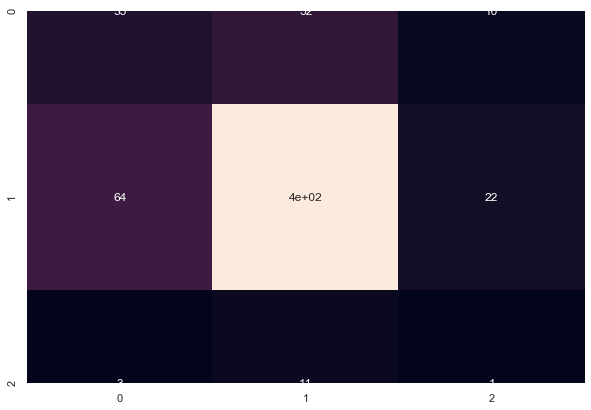

In [105]:
from sklearn.metrics import confusion_matrix
import seaborn as sns; sns.set()

fig, ax = plt.subplots(figsize=(10,10))   
mat = confusion_matrix(ay_test, adtc_preds)
ax = sns.heatmap(mat, cbar=False, square=True, annot=True)